In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tqdm.notebook as tqdm

In [2]:
import tensorflow as tf
#tf.config.set_visible_devices([], 'GPU')
import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical

In [3]:
templates_all = pd.read_csv("Purified_Templates.csv")

In [4]:
reactions_all = pd.read_csv("Purified_Reactions.csv")

In [5]:
templates_single = templates_all.drop_duplicates(subset="reaction_smarts")

In [6]:
fp = pd.read_csv("Purified_Fingerprints.csv")

In [7]:
temp_2 = templates_all[:200000]
temp_2.drop_duplicates(subset='reaction_smarts').to_csv('Purified_Templates_unique2.csv')

In [8]:
reactions_2 = reactions_all[:200000]
fp_2 = fp[:200000]
temp_2_unique = temp_2.drop_duplicates(subset='reaction_smarts')

In [9]:
smarts_templates = temp_2_unique['reaction_smarts'].to_list()
my_map = dict(list(enumerate(smarts_templates)))

In [10]:
inv_map = {v: k for k, v in my_map.items()}

In [19]:
indexes = np.arange(200000)
val_prop = 0.1
indexes_train, indexes_test = train_test_split(indexes, random_state=42, test_size=val_prop)

In [20]:
len(indexes_train)

180000

In [12]:
len(my_map)

57959

In [13]:
def fp_from_fp_db(fp_db):
    res = np.zeros(2048)
    list_idx = fp_db.split(" ")
    for el in list_idx[:-1]:
        lfp = el.split("-")
        n = len(lfp)
        if n == 1:
            res[int(lfp[0])] = 1
        elif n==2:
            res[int(lfp[0])] = int(lfp[-1])
        else:
            res[int(lfp[0])] = -int(lfp[-1])
    return res

In [14]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=32, n_channels=1,
                 n_classes=10, shuffle=True, _filename_fp="", _filename_templates = "", _data_fp = None, _data_templates=None):
        'Initialization'
        
        self.batch_size = batch_size
        
        self.list_IDs = list_IDs
        
        self.n_channels = n_channels
        
        self.n_classes = n_classes
        
        self.shuffle = shuffle
        
        self.p_bar = tqdm.tqdm(total = self.__len__())
        
        if (_filename_fp != "" and _filename_templates != ""):
            self.filename_fp = _filename_fp
            self.filename_templates = _filename_templates
        
            self.data_fp = pd.read_csv(_filename_fp)
            self.data_templates = pd.read_csv(_filename_templates)
        else:
            self.data_fp = _data_fp
            self.data_templates = _data_templates
            
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        
        self.p_bar.update(1)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' 
        # Initialization
        X = []
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i,val in enumerate(list_IDs_temp):
            # Store sample
           # print(val)
            r = fp_from_fp_db(self.data_fp.iloc[val,1])-fp_from_fp_db(self.data_fp.iloc[val,2])
            X.append(r)
            # Store class
            y[i] = inv_map[self.data_templates.iloc[val,4]]
        X = np.array(X)
        y = keras.utils.to_categorical(y, num_classes=self.n_classes)
        return np.array(X), y

In [15]:
n_s = temp_2_unique.shape[0]
batch_size_val = 256
nb_epochs = 30

In [12]:
from keras.models import Sequential
from keras.layers import Dense,Dropout
from tensorflow.keras.optimizers import Adam
adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)

model = Sequential()
model.add(Dense(512,input_shape=(2048,),activation="elu", name = "Dense_1"))
model.add(Dropout(0.4, name = "Dropout"))
model.add(Dense(57959, activation="softmax", name = "Dense_2_sortie"))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'top_k_categorical_accuracy'])
# Design model

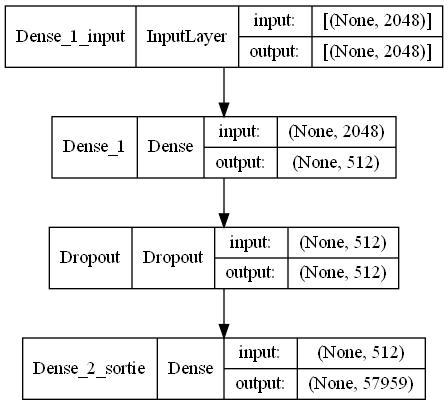

In [13]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='recommender_model_plot.png', show_shapes=True, show_layer_names=True)

In [21]:
training_generator = DataGenerator(indexes_train, batch_size=batch_size_val, n_channels=1,
                 n_classes=n_s, shuffle=True, _data_fp = fp_2, _data_templates = temp_2)

testing_generator = DataGenerator(indexes_test, batch_size=batch_size_val, n_channels=1, n_classes=n_s, shuffle=True, _data_fp = fp_2, _data_templates= temp_2)
# Train model on dataset

model.fit_generator(generator=training_generator,
                    use_multiprocessing=False,
                    verbose=2,
                    initial_epoch=0,
                    max_queue_size=20,
                    epochs=nb_epochs,
                    workers=20,
                    validation_data  = testing_generator)

  0%|          | 0/703 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

<ipython-input-21-e77c6364ed4f>:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=training_generator,


Epoch 1/30
703/703 - 85s - loss: 0.5810 - accuracy: 0.9398 - top_k_categorical_accuracy: 0.9708 - val_loss: 2.8228 - val_accuracy: 0.7396 - val_top_k_categorical_accuracy: 0.7884 - 85s/epoch - 121ms/step
Epoch 2/30
703/703 - 84s - loss: 0.3617 - accuracy: 0.9463 - top_k_categorical_accuracy: 0.9771 - val_loss: 2.1100 - val_accuracy: 0.7966 - val_top_k_categorical_accuracy: 0.8759 - 84s/epoch - 119ms/step
Epoch 3/30
703/703 - 84s - loss: 0.2026 - accuracy: 0.9579 - top_k_categorical_accuracy: 0.9913 - val_loss: 1.8730 - val_accuracy: 0.8454 - val_top_k_categorical_accuracy: 0.8878 - 84s/epoch - 120ms/step
Epoch 4/30
703/703 - 84s - loss: 0.1238 - accuracy: 0.9751 - top_k_categorical_accuracy: 0.9984 - val_loss: 1.9175 - val_accuracy: 0.8506 - val_top_k_categorical_accuracy: 0.8883 - 84s/epoch - 119ms/step
Epoch 5/30
703/703 - 83s - loss: 0.1077 - accuracy: 0.9785 - top_k_categorical_accuracy: 0.9986 - val_loss: 1.9602 - val_accuracy: 0.8525 - val_top_k_categorical_accuracy: 0.8891 - 83s

KeyboardInterrupt: 

In [22]:
model.save("our_recommender_model_2")

INFO:tensorflow:Assets written to: our_recommender_model_2\assets


In [23]:
ink = [fp_from_fp_db(fp.iloc[x,1])-fp_from_fp_db(fp.iloc[x,2]) for x in range(17000,30000)]
#print(ink.shape)
v = model.predict(np.array(ink))

ResourceExhaustedError: OOM when allocating tensor with shape[13000,57959] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:ConcatV2] name: concat

In [ ]:
v.shape

In [ ]:
res = [max(v[i])]

In [ ]:
max_index

In [ ]:
my_map[max_index]

In [ ]:
inv_map[templates_all.iloc[20000,4]]

In [ ]:
v[0][1975]